In [221]:
import nibabel as nib
import numpy as np
from sklearn.linear_model import Lasso,LassoCV,LinearRegression,Ridge
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor
from mpl_toolkits.mplot3d import Axes3D

from orelmisc import n_max,n_test_max,testpre,trainpre,saveCSV,y_org,shape_3d_org,mriX,mriY,mriZ
from preprocess import flatten,flatten_each_sample,loadData,flatten_each_sample,precompute_and_save

In [230]:
prep = lambda i: i #(i if i < 0.8 else 1) # round up to 1 if > 0.8
def prepPred(a):
  return map(prep,a)
cap = lambda p: min(1,max(0,p))
def pred_to_rgb(p):
  p = cap(p)
  v = p
  return (1-v,v,0.2)

# Ideas:
# -> use gradient as proprocessing?
# -> Do preprocessing with axis-specific avg and var

# DONE:
# -> split data into training and validation data.
#    otherwise we will have overfitting.

x_org = None
x_t_org = None
xa_org = None
d_org = None
y = np.array(y_org)
y_mean = np.full(n_max,np.mean(y),dtype=np.float64)[:n_test_max]
y_t_pred = None
yts_pred = None
y_t_pp = None
# ages only used for visualization, not for actual prediction!
y_age = np.array([20, 25, 61, 84, 23, 69, 83, 62, 72, 52, 52, 25, 19, 70, 26, 83, 83,73, 22, 21, 30, 30, 18, 68, 24, 22, 65, 80, 64, 24, 87, 80, 81, 72,23, 24, 70, 66, 22, 34, 82, 25, 23, 19, 20, 25, 23, 23, 71, 20, 86,81, 40, 57, 76, 84, 20, 18, 81, 74, 80, 41, 50, 88, 71, 82, 35, 23,88, 54, 44, 87, 80, 49, 48, 44, 21, 65, 78, 84, 48, 22, 43, 21, 31,23, 76, 39, 89, 21, 69, 60, 85, 23, 71, 48, 75, 78, 89, 51, 55, 22,73, 20, 74, 48, 18, 71, 78, 48, 74, 26, 75, 94, 49, 84, 22, 90, 26,81, 55, 80, 19, 20, 22, 77, 75, 37, 20, 72, 77, 29, 69, 74, 74, 64,80, 22, 90, 28, 21, 20, 85, 82, 71, 70, 21, 78, 87, 28, 46, 79, 24,54, 24, 51, 80, 78, 72, 93, 89, 75, 89, 58, 50, 58, 22, 96, 73, 78,28, 45, 18, 91, 20, 83, 43, 78, 71, 59, 83, 73, 64, 69, 20, 20, 28,86, 72, 90, 68, 90, 22, 67, 84, 48, 67, 78, 21, 54, 20, 22, 73, 20,27, 77, 72, 86, 33, 65, 31, 19, 65, 50, 27, 73, 50, 19, 80, 80, 88,55, 54, 72, 26, 80, 41, 81, 77, 79, 19, 71, 89, 88, 68, 20, 54, 23,22, 43, 21, 86, 81, 80, 22, 74, 55, 21, 20, 63, 51, 45, 46, 22, 23,80, 73, 84, 58, 20, 83, 67, 38, 26, 26, 77, 69, 24, 22, 26, 23, 20,54, 25, 55, 22, 23, 25])
y_best_032 = np.array([ 0.81847204,  0.50573795,  0.93090969,  0.31717665,  0.65878801,0.65853494,  0.78674158,  0.85413387,  0.8161635 ,  0.74410004,0.98012556,  0.86574596,  0.47575669,  1.03257789,  1.0320742 ,0.67692366,  0.89306248,  0.43085838,  0.32330623,  0.05377276, 0.69055024,  0.96929319,  0.95686   ,  0.61931571,  0.71027939, 0.8596436 ,  0.68943532,  1.05330405,  1.04323238,  1.08168815, 0.58241529,  0.98941415,  1.0549778 ,  1.02249065,  1.0669766 , 0.76781516,  0.34557697,  0.5036187 ,  0.8304998 ,  0.54938814, 0.8294184 ,  0.7123324 ,  0.24362318,  0.91444597,  0.75013124, 0.79937574,  0.93040339,  1.02289945,  1.09900176,  0.94116277, 1.09703621,  0.50893811,  0.99913353,  0.94345402,  1.12660423, 0.17037343,  0.70283305,  0.74629717,  1.11564053,  0.91921816, 0.73010714,  0.39167464,  0.93789409,  0.83643549,  1.18114375, 1.05861033,  0.88472935,  1.19744757,  0.53535786,  0.23757191, 0.22267435,  0.46199111,  1.03867736,  0.93574285,  0.5739508 , 0.71497959,  1.01055833,  0.77033857,  0.76873345,  1.08573322, 0.80972476,  0.49823087,  0.19792733,  0.93759774,  1.02559719, 0.26950831,  0.93154802,  0.90293775,  1.02432997,  0.60771731, 1.0193403 ,  0.67877216,  0.92362948,  1.05817318,  0.69507624, 0.19134573,  0.74054828,  0.51861395,  0.84969495,  0.66373192, 1.03840865,  0.70316599,  1.0086172 ,  0.05272077,  1.09057675, 0.97183384,  0.47850365,  1.00721712,  1.0446821 ,  0.83616127, 0.90068002,  0.98762267,  0.92533524,  0.85250945,  0.56305573, 0.9534472 ,  0.42522576,  0.69381758,  0.99701636,  1.06759829, 1.04266519,  1.08779049,  1.04994128,  0.92419757,  0.7922861 , 0.99383846,  1.1821566 ,  0.87126432,  0.92092674,  0.22844396, 0.96683719,  1.01791729,  1.01219959,  1.06896218,  1.05242259, 1.0534715 ,  0.72581669,  0.12924447])
prefix=None
alpha = 10
result = None
xa = []
x = None
x_t = None

In [231]:
space = 200 # 200 # 50 is smooth, 200 is a bit more noisy
nPercentiles = 20
margAxis = "X"
nMarginals = mriX # marginalize along x-axis
bStat = 7
bins = np.linspace(1,1900,space)
sbins = bins[:-1]+(bins[1]-bins[0])/2.0#bins used to plot the data
iMarginals = bStat + nPercentiles
iHist = iMarginals + nMarginals
ds = iHist + space-1 # sum,sum2,sum3,avg,var,mode, numper of percentiles and histogram

name = "output/"+str(space)+"_lasso_split_validated"
#fname = "mean_std_hist120_scale1.npy"
#fname = "mean_std_hist500_scale1.npy"
fname = "statistics_diff_hist" + str(space) + ".npy"
fnameMeanHist = "mean_hist" + str(space) + ".npy"
fnameMeanMarginals = "mean_marginals_"+str(margAxis)+".npy"

xa = np.load(fname)
x = xa[0:n_max,:]
x_t = xa[n_max:,:]

# plotting util
def plot3D(matrix,age,health,save_as=None,small=True,showbins=sbins):
  plt.clf()
  fig = plt.figure()
  if small is not True:
    fig.set_size_inches(12,12)
  ax = fig.gca(projection='3d')
  for i in range(0,len(matrix)):
      Z = matrix[i] # Nvoxels
      Y = showbins# intensity
      X = showbins*0+age[i] # age
      c = pred_to_rgb(health[i])
      ax.plot(X,Y,zs=Z,linewidth=0.3,color=c)
  ax.set_xlabel("age")
  ax.set_xlim([10,100])
  ax.set_ylabel("intensity of voxel")
  ax.set_zlabel("number of voxels")
  ax.view_init(elev=60, azim=330)
  plt.title("Diff Histograms by age and health (green = healthy, red = unhealty)")
  if save_as is not None:
    fig.savefig(save_as)
  plt.show()

In [232]:
def myloop(a):
    return (a,a*a,a*a*a)

myloopU = np.frompyfunc(myloop,1,3,dtype=np.float64)

def loadAndPreprocess(iStart=None):
    global d_org,x,x_t,xa,x_org,x_t_org,xa_org
    
    d_org = 6443008
    xa = np.zeros((n_max+n_test_max,ds))
    hists = np.zeros((n_max+n_test_max,space-1))
    marginals = np.zeros((n_max+n_test_max,nMarginals))
    
    i = iStart if iStart is not None else 0
    print "First loop. Calculate basic statistics and the absolute histogram"
    while i < n_max+n_test_max:
      if i % 5 == 0:
        print "Doing i = %s ..." % i
      
      n_i,pre,t_str = (n_max,"set_train/","train") if i < n_max else (n_test_max,"set_test/","test")
      filename = "%s%s_%s.nii" % (pre,t_str,i%n_max+1)
      data = nib.load(filename).get_data()
      sum = 0.0
      sum2 = 0.0
      sum3 = 0.0
      avg = 0.0
      var = 0.0
      margs = np.sum(data.reshape((mriX,mriY*mriZ)),axis=1)
      marginals[i,:] = margs
      data = data.ravel()
      res = myloopU(data)
      sum = np.sum(res[0])
      sum2 = np.sum(res[1])
      sum3 = np.sum(res[2])
      avg = sum / float(d_org)
      var = sum2 / float(d_org-1) - avg*avg
      hist = np.histogram(data,bins=bins)[0]
      percentiles = np.linspace(0,100,nPercentiles)
      iMax,hMax = max(enumerate(hist),key=lambda x:x[1])
      percs = np.percentile(hist,percentiles)
      xa[i,:bStat] = [sum,sqrt(sum2),pow(sum3,1/3.0),avg,var,iMax,hMax]
      xa[i,bStat:iMarginals] = percs
      hists[i] = hist
      i = i+1
    
    meanHist = np.mean(hists[:n_max,:],axis=0)
    meanMarginals = np.mean(marginals[:n_max,:],axis=0)
    
    np.save(fnameMeanHist,meanHist)
    print "Saved mean hist into into %s" % fnameMeanHist
    np.save(fnameMeanMarginals,meanMarginals)
    print "Saved mean marginals into into %s" % fnameMeanMarginals
    
    print "Second loop. Compute differences to mean-histogram / mean-marginals and save matrix"
    i = 0
    while i < n_max+n_test_max:
      xa[i,iHist:] = hists[i]-meanHist
      xa[i,iMarginals:iHist] = marginals[i]-meanMarginals
      i=i+1
    
    np.save(fname,xa)
    print "Saved all-including data matrix into. %s\n================== FIN =====================" % fname
    x = xa[0:n_max]
    x_t=xa[n_max:]

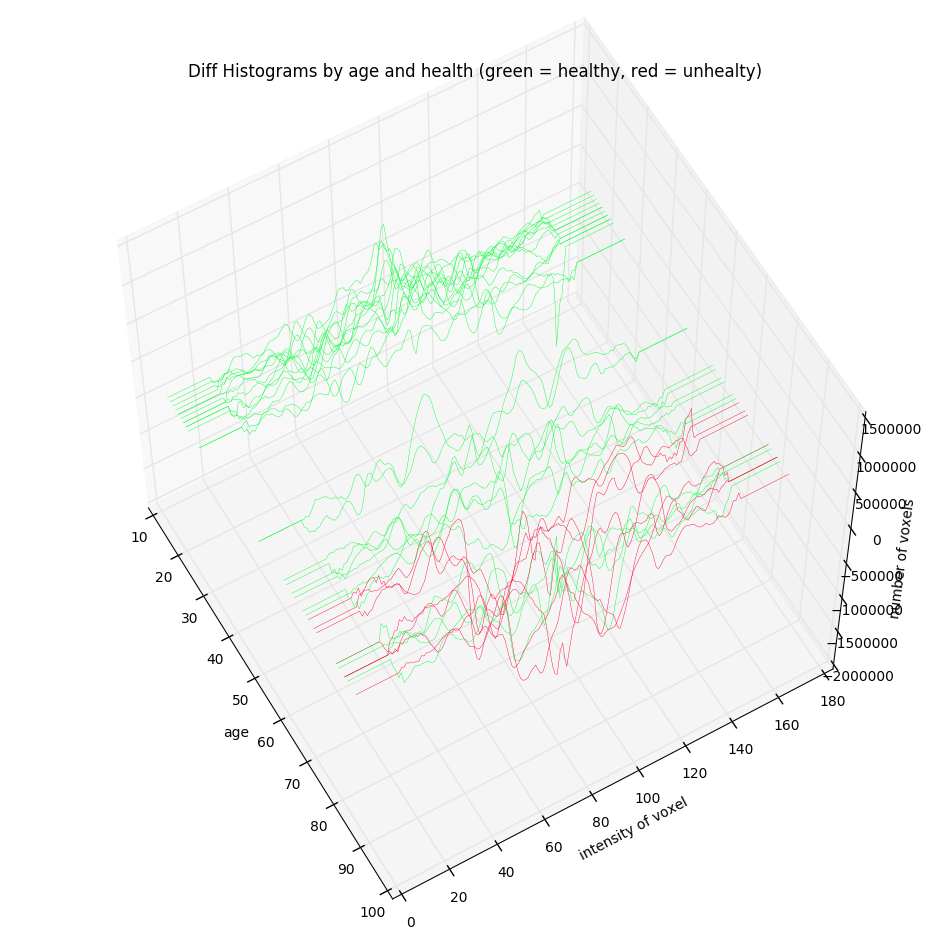

In [233]:
#print y
#loadAndPreprocess()

plot3D(matrix=x[:33,iMarginals:iHist],age=y_age,health=y,showbins=np.linspace(0.5,mriX+0.5,mriX),small=False)

## Splitting our data into training and test data

Indices for total data: 
healthy 211 :  [ 0  1  2  3  4  5  6  7  9 10 11 12 14 18 19] ...
sick 67 :  [ 8 13 15 16 17 27 30 36 37 48 51 54 55 58 60] ...

Indices for splitted data: 
healthy training  147 :  [123 198  98 149  53  22   5 208 228  63] ...
healthy test  64 :  [111  42 200 271 171 119   4  62  23  76] ...
sick training  46 :  [161 121  37  77 225 255 242 206 229 261] ...
sick test  21 :  [158  15 181 197 143 249 177 241 194 167] ...
=============== Healthy training ===============


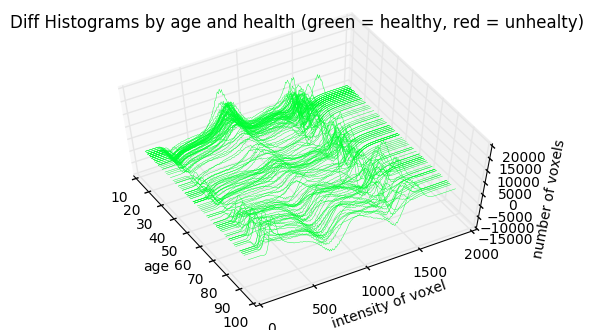

=============== Healthy test ===============


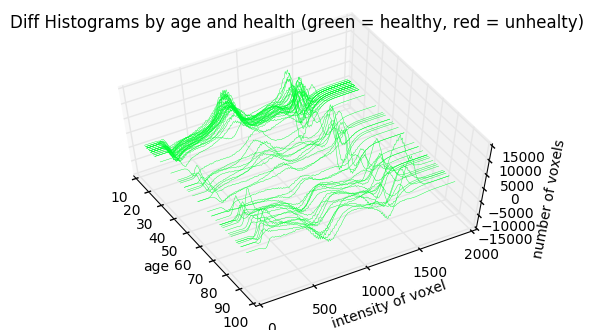

=============== sick training ===============


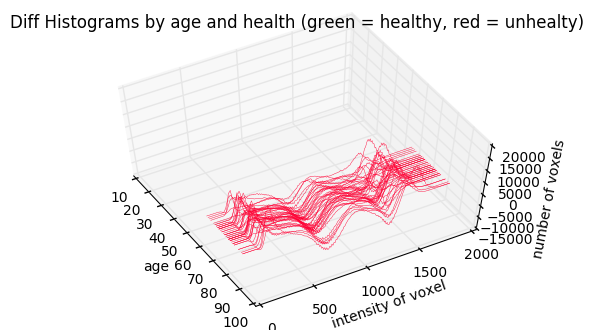

=============== sick test ===============


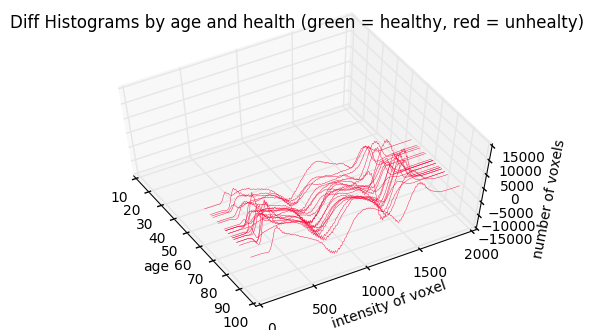

Splitted data into test and validation data


In [234]:
from sklearn.model_selection import train_test_split
# xa. all data
# x. public training data
# y. public training targets
# x_t public to be predicted data

# xtr. training data
# ytr. training targets
# xts. validation data
# yts. validation targets

# indices for splitting
ones = np.array(filter(lambda i: y[i]==1,range(0,n_max)))
zeros = np.array(filter(lambda i: y[i]==0,range(0,n_max)))
# split the indices
onestr,onests,_,_ = train_test_split(ones,ones*0,test_size=0.3,random_state=1)
zerostr,zerosts,_,_ = train_test_split(zeros,zeros*0,test_size=0.3,random_state=1)

# plot the data. a few random states have been tried to to make sure all splits are balanced enough.
print "Indices for total data: "
print "healthy",len(ones),": ",ones[:15],"..."
print "sick",len(zeros),": ",zeros[:15],"...\n"

print "Indices for splitted data: "
print "healthy training ",len(onestr),": ",onestr[5:15],"..."
print "healthy test ",len(onests),": ",onests[5:15],"..."
print "sick training ",len(zerostr),": ",zerostr[5:15],"..."
print "sick test ",len(zerosts),": ",zerosts[5:15],"..."

print "="*15,"Healthy training","="*15
plot3D(matrix=x[:,iHist:][onestr],age=y_age[onestr],health=y[onestr])
print "="*15,"Healthy test","="*15
plot3D(matrix=x[:,iHist:][onests],age=y_age[onests],health=y[onests])
print "="*15,"sick training","="*15
plot3D(matrix=x[:,iHist:][zerostr],age=y_age[zerostr],health=y[zerostr])
print "="*15,"sick test","="*15
plot3D(matrix=x[:,iHist:][zerosts],age=y_age[zerosts],health=y[zerosts])

xtr = np.vstack((x[onestr],x[zerostr]))
xts = np.vstack((x[onests],x[zerosts]))
ytr = np.hstack((y[onestr],y[zerostr]))
yts = np.hstack((y[onests],y[zerosts]))

print "Splitted data into test and validation data"

In [240]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import log_loss

def makeGaussianProcess():
  global y_t_pred,resulty
  prefix = "%s_GPs_FULL"%(name)
  kernel = RBF(1e5,(1e-4,1e15))
  model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
  y_t_pred = model.fit(x[:,:5],y).predict(x_t[:,:5])
  r = model.score(x[:,:5],y)
  print("score r = %s"%r)
  print "Coefficients: %s" % model.get_params()
  return prefix,model

def makeSVDLassoPrediction(comps,al=15):
  global y_t_pred,result,alpha
  alpha = al
  svd = TruncatedSVD(n_components=comps,n_iter=20)
  print "Prediction with alpha = %s" % alpha
  prefix = "%sSVD_Lasso_comps%s_alpha%s_FULL"%(name,comps,alpha)
  #x1 = np.concatenate((x[:,:5],svd.fit_transform(x)),axis=1)
  #x1 = svd.fit_transform(x)
  #x_t1 = svd.transform(x_t)
  #x_t1 = np.concatenate((x_t[:,:5],svd.transform(x_t)),axis=1)
   
  #x1 = x[:,iHist:]; x_t1 = x_t[:,iHist:]
  #x1 = x[:,:iHist]; x_t1 = x_t[:,:iHist]
  x1 = x[:,:]; x_t1 = x_t[:,:] 

  lasso = Lasso(alpha=alpha)
  y_t_pred = lasso.fit(x1,y).predict(x_t1)
  r = lasso.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  print "Coefficients: %s...." % lasso.coef_[:5]
  #print "singular values of x0: %s" % np.sort(x1[0])
  plt.clf()
  plt.plot(np.sort(x1[0]))
  plt.show()
  return prefix,lasso
       
    
def makeAdaDefaultBaseEstimatorPrediction(n_est,max_depth,msplit):
  global y_t_pred,yts_pred,result,y_t_pp
  print "Prediction default decision tree (max_depth=%s, msplit=%s) and #estimators = %s" % (max_depth,msplit,n_est)
  prefix = "%s_AdaBoost_est%s_default_decision_tree_depth%s_msplit%s"%(name,n_est,max_depth,msplit)
  model = AdaBoostRegressor(
            DecisionTreeRegressor(random_state=1,max_depth=max_depth,min_samples_split=msplit)
    ,n_estimators=n_est,random_state=1)
  xtr1 = xtr[:,:] # use all data
  xts1 = xts[:,:] # use all data
  x_t1 = x_t[:,:]
  yts_pred = model.fit(xtr1,ytr).predict(xts1)
  y_t_pred = model.predict(x_t1)
  
  y_t_pp = prepPred(y_t_pred)
  ltr = log_loss(ytr,prepPred(model.predict(xtr1)))
  lts = log_loss(yts,prepPred(yts_pred))
  ltm= log_loss(yts,y_mean[:len(yts)])
  print("\n")
  print("============================    Log-Loss train           ltr = %.3f =========="%ltr)
  print("============================    Log-Loss test            lts = %.3f =========="%lts)
  print("============================    Log-Loss mean prediciton ltm = %.3f ==========\n\n"%ltm)
  plt.clf()
  plt.plot([np.max(np.abs(ws)) for ws in model.estimator_weights_],"ro")
  plt.title("abs-largest_est-weight")
  plt.savefig(prefix+"_abs-largest_est-weight.png")
  plt.show()
  prefix = "%s_expected_score%.3f"%(prefix,lts)
  return prefix,model

def makeBaggingBoostLassoPrediction(al,n_est,feats,samps):
  global y_t_pred,yts_pred,result,alpha,y_t_pp
  alpha = al
  print "Prediction with alpha = %s and #estimators = %s" % (alpha,n_est)
  prefix = "%s_BaggingRegressor_est%s_feats%s_samps%s_Lasso_alpha%s"%(name,n_est,feats,samps,alpha)
  model = BaggingRegressor(Lasso(alpha=alpha),
                           n_estimators=n_est,random_state=1,
                          max_features=feats,
                          max_samples=samps)
  xtr1 = xtr[:,:] # use all data
  xts1 = xts[:,:] # use all data
  x_t1 = x_t[:,:]
  yts_pred = model.fit(xtr1,ytr).predict(xts1)
  y_t_pred = model.predict(x_t1)
  
  y_t_pp = prepPred(y_t_pred)
  ltr = log_loss(ytr,prepPred(model.predict(xtr1)))
  lts = log_loss(yts,prepPred(yts_pred))
  ltm= log_loss(yts,y_mean[:len(yts)])
  print("\n")
  print("============================    Log-Loss train           ltr = %.3f =========="%ltr)
  print("============================    Log-Loss test            lts = %.3f =========="%lts)
  print("============================    Log-Loss mean prediciton ltm = %.3f ==========\n\n"%ltm)
  prefix = "%s_expected_score%.3f"%(prefix,lts)
  return prefix,model
    
def makeAdaLassoPrediction(al,n_est):
  global y_t_pred,yts_pred,result,alpha,y_t_pp
  alpha = al
  print "Prediction with alpha = %s and #estimators = %s" % (alpha,n_est)
  prefix = "%s_AdaBoost_est%s_Lasso_alpha%s"%(name,n_est,alpha)
  model = AdaBoostRegressor(Lasso(alpha=alpha),n_estimators=n_est,random_state=0)
  xtr1 = xtr[:,:] # use all data
  xts1 = xts[:,:] # use all data
  x_t1 = x_t[:,:]
  yts_pred = model.fit(xtr1,ytr).predict(xts1)
  y_t_pred = model.predict(x_t1)
  
  y_t_pp = prepPred(y_t_pred)
  ltr = log_loss(ytr,prepPred(model.predict(xtr1)))
  lts = log_loss(yts,prepPred(yts_pred))
  ltm= log_loss(yts,y_mean[:len(yts)])
  print("\n")
  print("============================    Log-Loss train           ltr = %.3f =========="%ltr)
  print("============================    Log-Loss test            lts = %.3f =========="%lts)
  print("============================    Log-Loss mean prediciton ltm = %.3f ==========\n\n"%ltm)
  coeffs = model.estimators_[-1].coef_
  print "Last estimator coefficients: %s..." % coeffs[:5]
  bla1 = (sorted(enumerate(coeffs),key=lambda x:-abs(x[1]))[:10])
  print "Most-important features (by max abs):"
  for s in bla1:
    print s
  plt.clf()
  plt.plot([np.max(np.abs(ws)) for ws in model.estimator_weights_],"ro")
  plt.title("abs-largest_est-weight"%(bla1))
  plt.savefig(prefix+"_abs-largest_est-weight.png")
  plt.show()
  prefix = "%s_expected_score%.3f"%(prefix,lts)
  return prefix,model
    
def makeLassoPrediction(al):
  global y_t_pred,yts_pred,result,alpha,y_t_pp
  alpha = al
  print "Prediction with alpha = %s" % alpha
  prefix = "%s_LassoPure_alpha%s_FULL"%(name,alpha)
  model = Lasso(alpha=alpha)
  xtr1 = xtr[:,:] # use all data
  xts1 = xts[:,:] # use all data
  x_t1 = x_t[:,:]
  yts_pred = model.fit(xtr1,ytr).predict(xts1)
  y_t_pred = model.predict(x_t1)
  
  y_t_pp = prepPred(y_t_pred)
  ltr = log_loss(ytr,prepPred(model.predict(xtr1)))
  lts = log_loss(yts,prepPred(yts_pred))
  ltm= log_loss(yts,y_mean[:len(yts)])
  print("\n")
  print("============================    Log-Loss train           ltr = %.3f =========="%ltr)
  print("============================    Log-Loss test            lts = %.3f =========="%lts)
  print("============================    Log-Loss mean prediciton ltm = %.3f ==========\n\n"%ltm)
  coeffs = model.coef_
  print "Last estimator coefficients: %s..." % coeffs[:5]
  bla1 = (sorted(enumerate(coeffs),key=lambda x:-abs(x[1]))[:10])
  print "Most-important features (by max abs):"
  for s in bla1:
    print s
  prefix = "%s_expected_score%.3f"%(prefix,lts)
  return prefix,model

def makeLassoCVPrediction(cv=3):
  global y_t_pred,result
  print "Prediction with cv = %s" % 3
  prefix = "%s_LassoCV_FULL"%(name)
  lasso = LassoCV(cv=cv)
  y_t_pred = lasso.fit(x,y).predict(x_t)
  r = lasso.score(x,y)
  m_log_alphas = -np.log10(lasso.alphas_)
  plt.plot(m_log_alphas, lasso.mse_path_, ':')
  plt.show()
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  #print "Coefficients: %s" % lasso.coef_
  return prefix,lasso


def makeLinearRegression():
  global y_t_pred,result
  prefix = "%s_LinReg_FULL"%(name)
  linreg = LinearRegression()
  y_t_pred = linreg.fit(x,y).predict(x_t)
  r = linreg.score(x,y)
  print("score r = %s"%r)
  print "Intercept: %s" % linreg.intercept_
  print "Coefficients: %s" % linreg.coef_
  print "Residues: %s" % linreg.residues_
  return prefix,linreg

In [241]:
def doStuff(al=15,comps=n_max-1,kernel="rbf",n_est=120,max_depth=7,msplit=10,feats=0.3,samps=0.3):
  global prefix,result
  #loadAndPreprocess()
  
  #prefix,model = makeLassoPrediction(al=al)
  #prefix,model = makeAdaDefaultBaseEstimatorPrediction(n_est=n_est,max_depth=max_depth,msplit=msplit)
  prefix,model = makeAdaLassoPrediction(al=al,n_est=n_est)
  #prefix,model = makeLassoPrediction(al=al)
  #prefix,model = makeBaggingBoostLassoPrediction(al=al,n_est=n_est,feats=feats,samps=samps)
  #prefix,model = makeSVDLassoPrediction(al=al,comps=comps)
  #prefix,model = makeLassoCVPrediction(cv=3)
  #prefix,model = makeLinearRegression()
  #prefix,model = makeRidgePrediction(al=al)
  #prefix,model = makeGaussianProcess()
  #prefix,model = make_KPCA_prediction(kernel=kernel,al=al)
  
  # Bagging Lasso works poorly when validated and on the public score. forget this.
  #prefix,model = makeBaggingBoostLassoPrediction(al=al,n_est=n_est,feats=feats,samps=samps)
  
  savePrediction()
  
  visualize(y,y_t_pp,prefix)
  
  # retuns a colleciton of stuff to return
  print "Variables available in 'result'"
  result = (x,y,x_t,y_t_pred,y_t_pp,model)

def visualize(y,y_t_pp,prefix):
  plt.clf()
  plt.plot(np.array(y_t_pp)-y_mean,"bo")
  plt.savefig(prefix + "_diff_to_score_mean.png")
  plt.show()
  plt.clf()
  plt.title("PREDICTIONS sorted (0=unhealty, 1=healthy)")
  plt.plot(sorted(y_t_pp),"bo")
  plt.savefig(prefix + "_plot.png")
  print("Saved age diagrams as %s"%(prefix+"*.png"))
  plt.show()
  plot3D(matrix=xts[:,iHist:],health=yts_pred,age=y_age[np.hstack((onests,zerosts))],save_as=prefix + "_all_hists.png",small=False)

def savePrediction():
    savedFilename = saveCSV(map(cap,y_t_pp),prefix)
    print("Saved predictions into %s" % savedFilename)

Prediction with alpha = 0.01 and #estimators = 25


============================    Log-Loss train           ltr = 0.063 ==========
============================    Log-Loss test            lts = 1.195 ==========
============================    Log-Loss mean prediciton ltm = 0.559 ==========


Last estimator coefficients: [ 0.  0.  0.  0.  0.]...
Most-important features (by max abs):
(18, 6.037904641678567e-06)
(42, 5.7671435499182503e-06)
(44, -5.535540169744659e-06)
(40, -4.7243655731620776e-06)
(28, 4.5124867072196278e-06)
(56, -4.2525792417498886e-06)
(49, -4.0000852495794343e-06)
(23, 3.9687391789575973e-06)
(27, -3.6941992569078033e-06)
(47, 3.6079979499632375e-06)


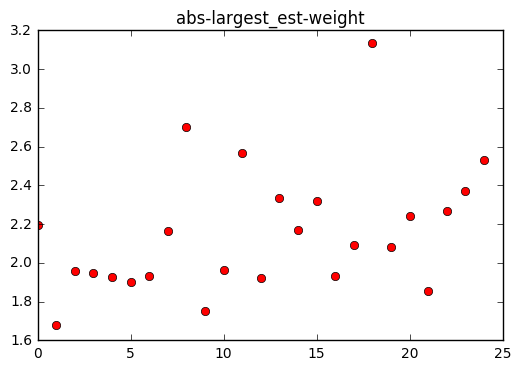

Saved predictions into output/200_lasso_split_validated_AdaBoost_est25_Lasso_alpha0.01_expected_score1.195.csv


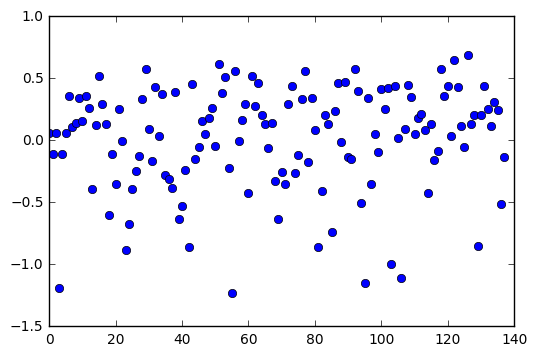

Saved age diagrams as output/200_lasso_split_validated_AdaBoost_est25_Lasso_alpha0.01_expected_score1.195*.png


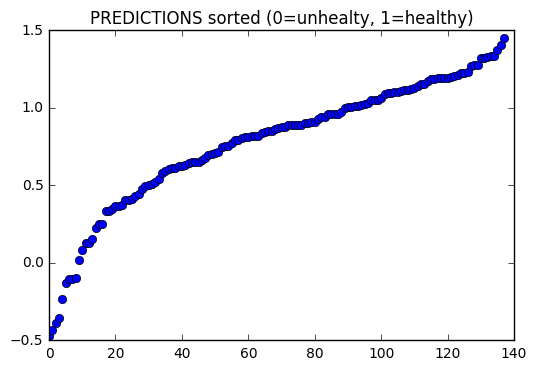

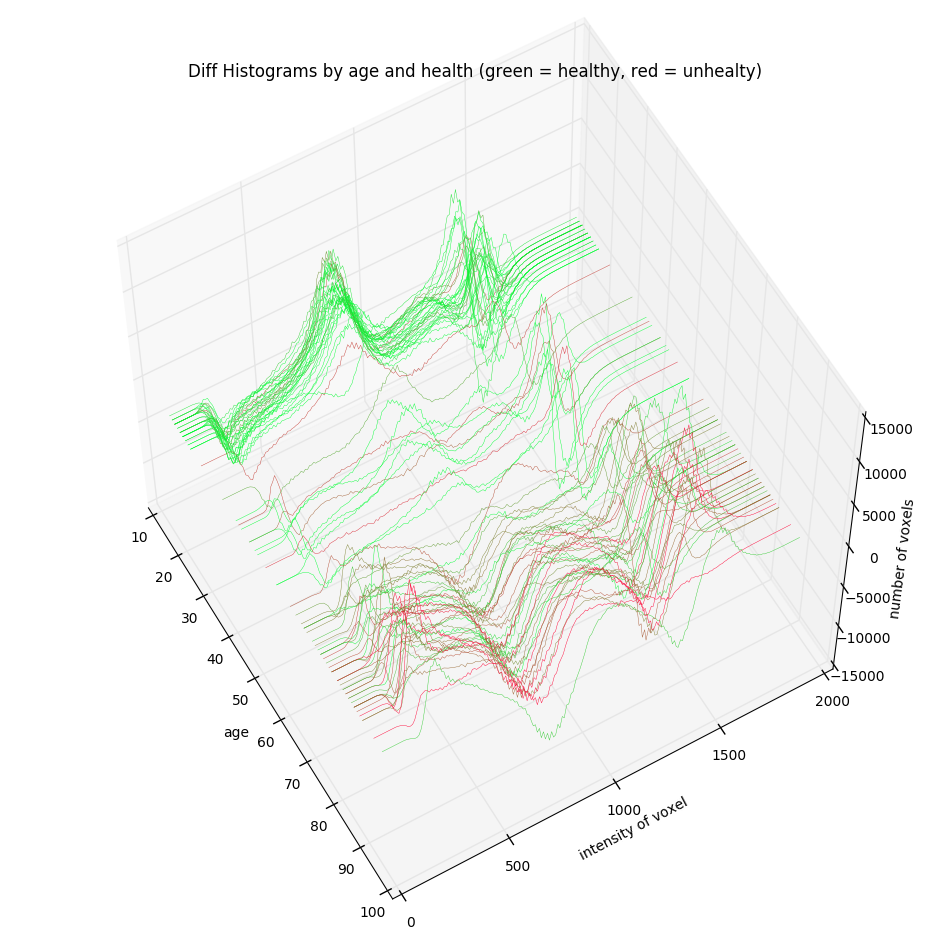

Variables available in 'result'


In [243]:
doStuff(al=0.01,n_est=25,max_depth=2,msplit=70)

# Histogram deviation from mean and Lasso coefficients

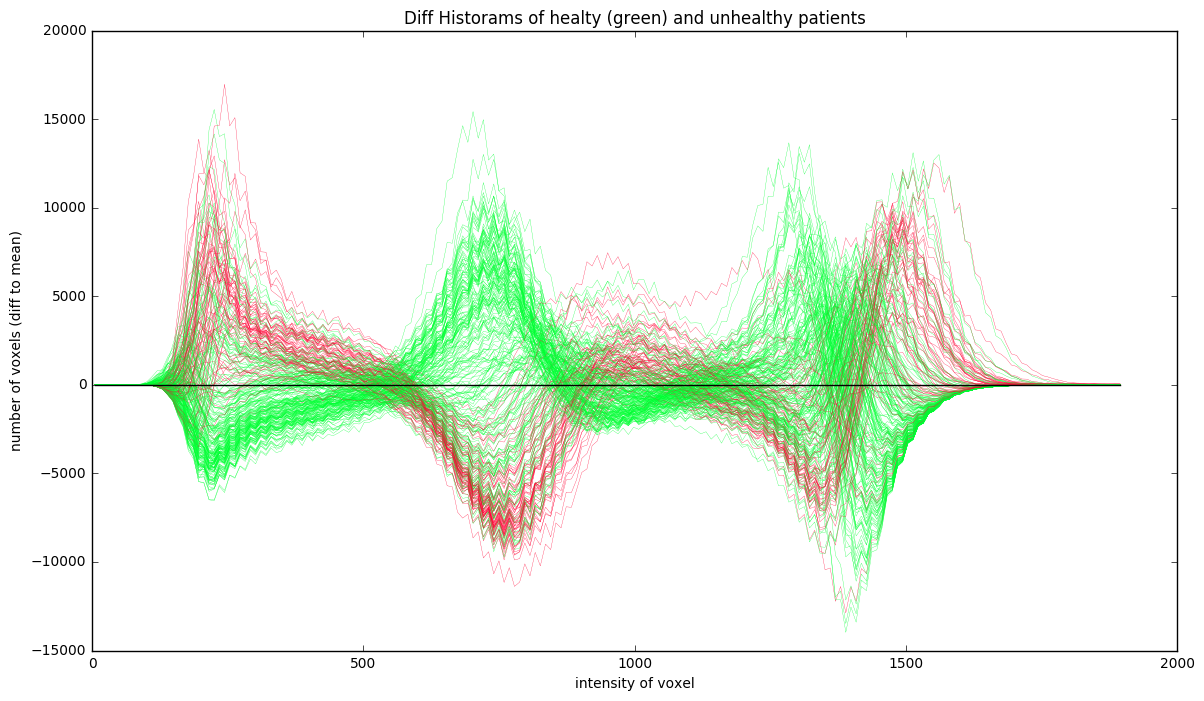

In [220]:
plt.clf()
g = "hist_viz_" + str(space)
fig = plt.figure(1)
fig.set_size_inches(14,8)
dos = range(0,n_max)
for si,i in enumerate(dos):
    s = "i=%s,healthy=%s" % (i,y[i])
    c = pred_to_rgb(y[i])
    plt.plot(sbins,x[i,iHist:],color=c,linewidth=0.2)
plt.plot(sbins,x[0,iHist:]*0,color="black",linewidth=1)
plt.ylabel("number of voxels (diff to mean)")
plt.xlabel("intensity of voxel")
plt.title("Diff Historams of healty (green) and unhealthy patients")
plt.savefig(g + ".png")
plt.show()

## Visualize all Histograms deviations per Age

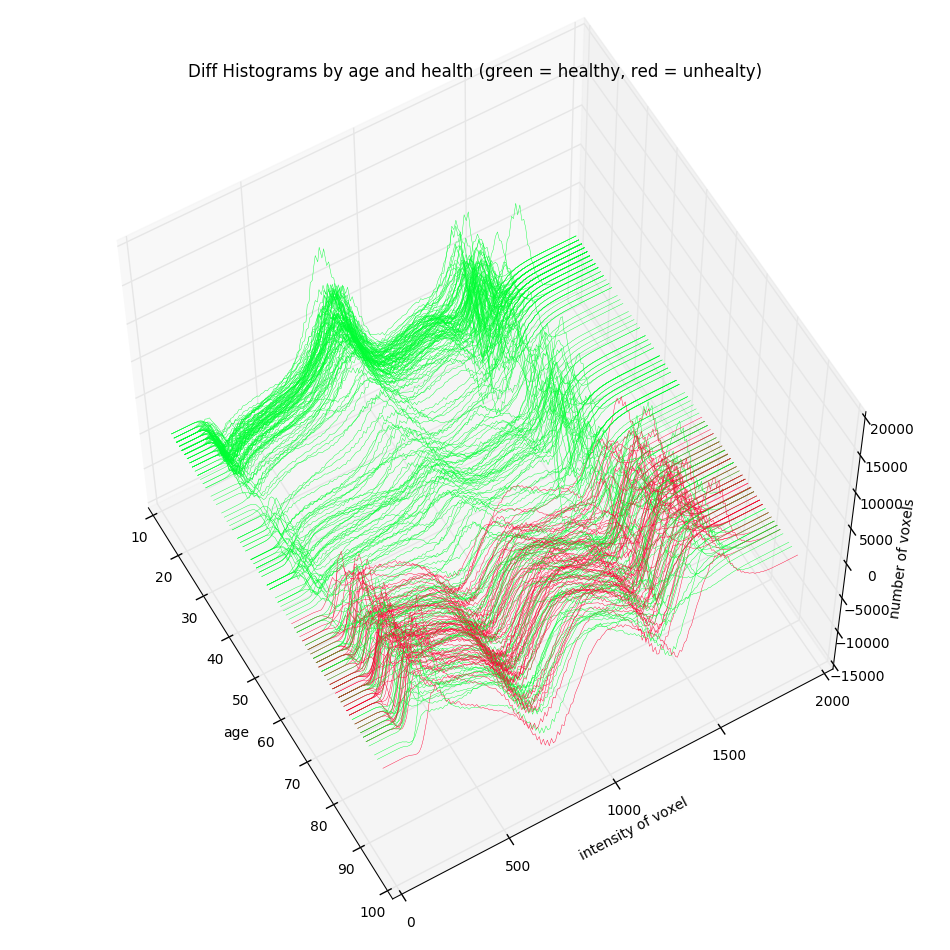

In [212]:
plot3D(x[:,iHist:],y_age,y,save_as="all-histograms-by-health-and-age_"+str(space)+".png",small=False)